# First script

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_01.png
train_02.png
train_03.png
train_04.png
train_05.png
(512, 512)
0.003921569 0.9882353
float32


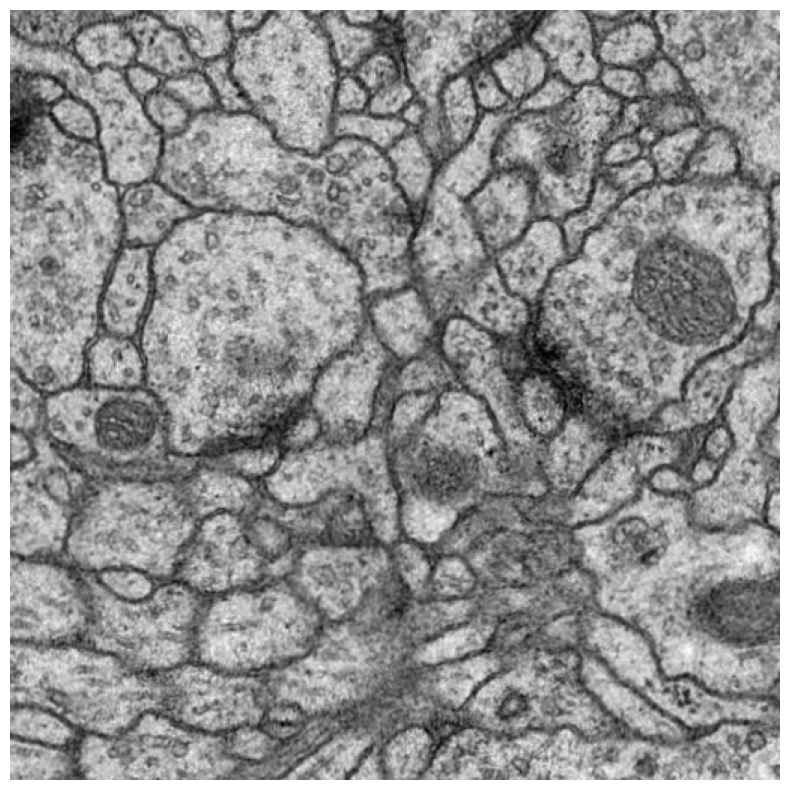

In [80]:
folder = 'data/train_images/'

# read train_images
def read_train_images(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        print(filename)
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        # normalize the image to [0, 1]
        img = img.astype(np.float32) / 255.0
        images.append(img)
    return images

images = read_train_images(folder)

# show the first image
print(images[0].shape)
print(images[0].min(),images[0].max())
print(images[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(images[0], cmap = 'gray')
plt.axis('off')
plt.show()

labels_01.png
labels_02.png
labels_03.png
labels_04.png
labels_05.png
(512, 512)
0.0 1.0
float32


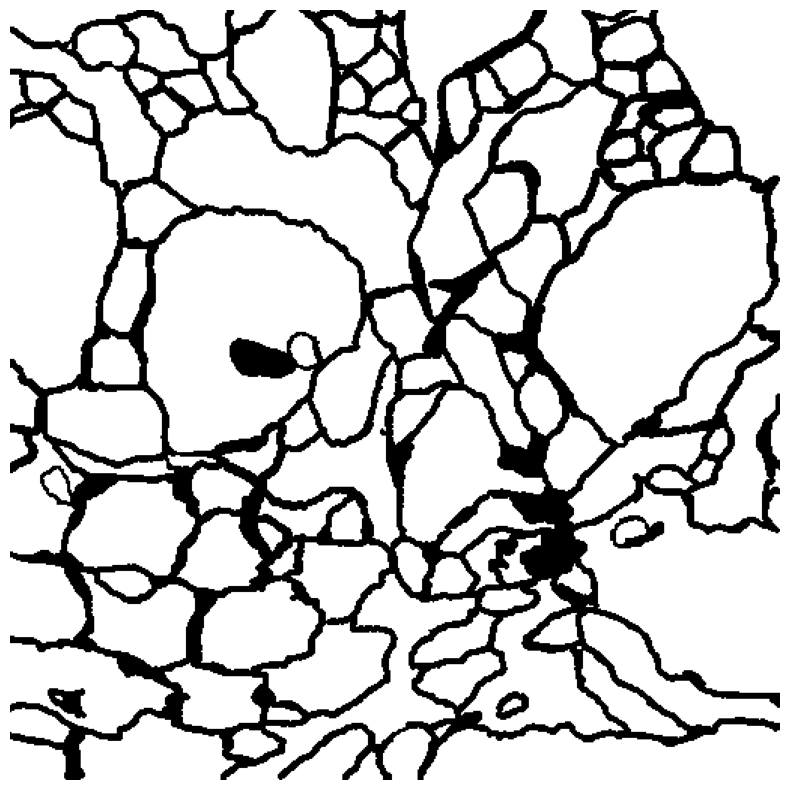

In [81]:
folder = 'data/train_labels/'

labels = read_train_images(folder)

# show the first image
print(labels[0].shape)
print(labels[0].min(),labels[0].max())
print(labels[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(labels[0], cmap = 'gray')
plt.axis('off')
plt.show()

This is the reason why we import the images as one channel images: 

In [5]:
# Check if all three channels are identical
# is_grayscale = (images[0][:, :, 0] == images[0][:, :, 1]).all() and (images[0][:, :, 1] == images[0][:, :, 2]).all()
# print("Is the image grayscale?", is_grayscale)

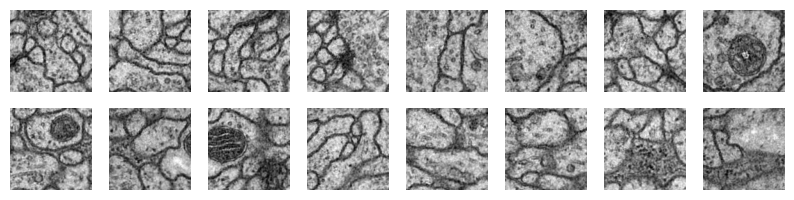

In [82]:
# do patches of the images, of 128x128
def create_patches(images, patch_size=128):
    patches = []
    for image in images:
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    patches.append(patch)
    
    return patches

# create patches of the first image
patches_images = create_patches(images, patch_size=128)

patches_images_ex = patches_images[16*3:16*4]

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_images_ex):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

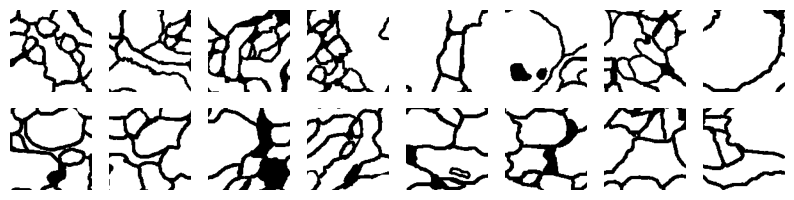

In [83]:
# create patches of the first image
patches_labels = create_patches(labels, patch_size=128)

patches_labels_ex = patches_labels[16*3:16*4]

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_labels_ex):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

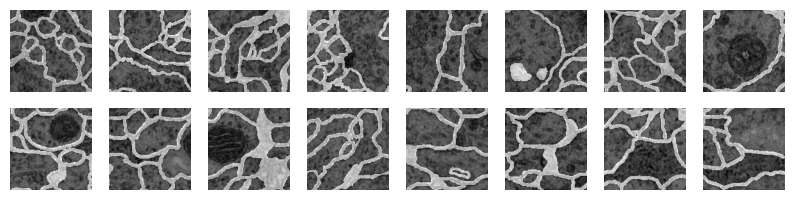

In [84]:
# show the images and above the labels use patches_images and patches_labels
plt.figure(figsize=(10, 10))
for i in range(0, 16):
    plt.subplot(8, 8, i+1)
    #plt.imshow(patches_images[i], cmap='gray')
    plt.imshow(patches_images_ex[i]-patches_labels_ex[i], cmap='gray')
    plt.axis('off')
plt.show()


# MODEL

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):  # grayscale: in_channels=1
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.double_conv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.double_conv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(128, 64)

        # Final output
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.out_conv(d1))  # for binary segmentation

# Example
model = UNet(in_channels=1, out_channels=1)
#x = torch.randn(1, 1, 128, 128)  # grayscale image
x = patches_images[0]  # use the first patch
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions
y = model(x)
print(y.shape)  # should be [1, 1, 128, 128]

torch.Size([1, 1, 128, 128])


# DATASET

In [87]:
from torch.utils.data import Dataset

class PatchDataset(Dataset):
    def __init__(self, image_patches, label_patches, transform=None):
        self.image_patches = image_patches
        self.label_patches = label_patches
        self.transform = transform

    def __len__(self):
        return len(self.image_patches)

    def __getitem__(self, idx):
        image = self.image_patches[idx]
        label = self.label_patches[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [88]:
from torch.utils.data import DataLoader
import torch

# maybe convert your patches to tensors first if they are still numpy arrays
image_patches = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in patches_images]
label_patches = [torch.tensor(lbl, dtype=torch.long).unsqueeze(0) for lbl in patches_labels]

# create dataset
patch_dataset = PatchDataset(image_patches, label_patches)

# create dataloader
train_loader = DataLoader(patch_dataset, batch_size=16, shuffle=True)

In [89]:
model = UNet(in_channels=1, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

In [92]:
'''
for images, labels in train_loader:
    preds = model(images)   
    print(preds.shape)           # preds shape: [batch_size, 1, 128, 128]
    #preds = preds.squeeze(1)            # shape: [batch_size, 128, 128] if needed
    loss = loss_fn(preds, labels.float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
'''

'\nfor images, labels in train_loader:\n    preds = model(images)   \n    print(preds.shape)           # preds shape: [batch_size, 1, 128, 128]\n    #preds = preds.squeeze(1)            # shape: [batch_size, 128, 128] if needed\n    loss = loss_fn(preds, labels.float())\n\n    optimizer.zero_grad()\n    loss.backward()\n    optimizer.step()\n'

In [91]:
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for images, labels in train_loader:
        images = images.float()        # Ensure images are float
        labels = labels.float()         # Ensure labels are float

        preds = model(images)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}")

Epoch [1/10] - Average Loss: 0.7312
Epoch [2/10] - Average Loss: 0.5515
Epoch [3/10] - Average Loss: 0.5361
Epoch [4/10] - Average Loss: 0.4625
Epoch [5/10] - Average Loss: 0.3999
Epoch [6/10] - Average Loss: 0.3575
Epoch [7/10] - Average Loss: 0.3481
Epoch [8/10] - Average Loss: 0.3391
Epoch [9/10] - Average Loss: 0.3344
Epoch [10/10] - Average Loss: 0.3322


In [102]:
import matplotlib.pyplot as plt
import torch

# Get one batch
images, labels = next(iter(train_loader))

# Move to float (and GPU if needed)
images = images.float()
labels = labels.float()

# Predict
model.eval()      # important! deactivate dropout, batchnorm, etc
with torch.no_grad():
    preds = model(images)

# If you want, apply Sigmoid if your model doesn't have it
# preds = torch.sigmoid(preds)

# Take first image and prediction
image = images[0, 0, :, :].cpu().numpy()      # [0, 0, :, :] -> first image, first channel
label = labels[0, 0, :, :].cpu().numpy()
pred = preds[0, 0, :, :].cpu().numpy()


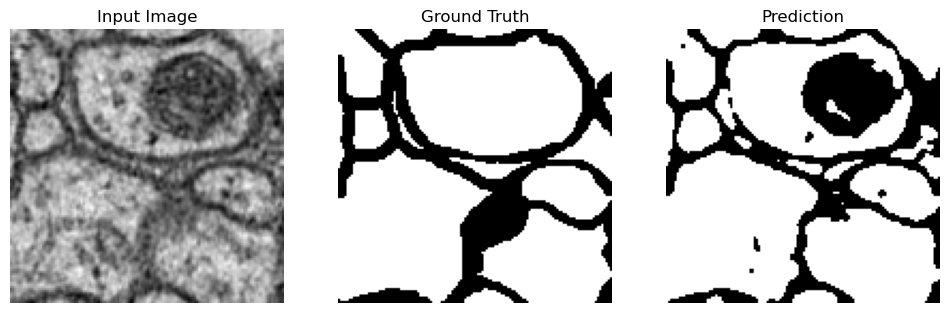

In [103]:
# Binarize prediction
binary_pred = (pred >= 0.50).astype(float)   # or .astype(np.uint8)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth')
plt.imshow(label, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Prediction')
plt.imshow(binary_pred, cmap='gray')
plt.axis('off')

plt.show()